# MLB Elo System

To begin, we'll just be looking at the 2024 season, just so I can get a feel for how the system should work, before moving onto a longer analysis.

In [ ]:
import polars as pl

In [ ]:
df = pl.read_csv("data/singleseason/2024csvs/2024gameinfo.csv")

In [ ]:
df.head()

gid,visteam,hometeam,site,date,number,starttime,daynight,innings,tiebreaker,usedh,htbf,timeofgame,attendance,fieldcond,precip,sky,temp,winddir,windspeed,oscorer,forfeit,suspend,umphome,ump1b,ump2b,ump3b,umplf,umprf,wp,lp,save,gametype,vruns,hruns,wteam,lteam,line,batteries,lineups,box,pbp,season
str,str,str,str,i64,i64,str,str,i64,i64,bool,str,i64,i64,str,str,str,i64,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,str,str,str,str,str,str,str,i64
"""SDN202403200""","""LAN""","""SDN""","""SEO01""",20240320,0,"""7:05PM""","""night""",9,2,true,null,185,15952,"""unknown""","""none""","""dome""",72,"""unknown""",0,"""zaveb701""",null,null,"""barkl901""","""torrc901""","""viscj901""","""rehaj901""","""(none)""","""(none)""","""hudsd001""","""britj003""","""phile001""","""regular""",5,2,"""LAN""","""SDN""","""y""","""both""","""y""","""y""","""y""",2024
"""LAN202403210""","""SDN""","""LAN""","""SEO01""",20240321,0,"""7:05PM""","""night""",9,2,true,null,222,15928,"""unknown""","""none""","""dome""",72,"""unknown""",0,"""zaveb701""",null,null,"""fleta901""","""viscj901""","""rehaj901""","""barkl901""","""(none)""","""(none)""","""kingm002""","""yamay001""","""suarr002""","""regular""",15,11,"""SDN""","""LAN""","""y""","""both""","""y""","""y""","""y""",2024
"""ARI202403280""","""COL""","""ARI""","""PHO01""",20240328,0,"""7:10PM""","""night""",9,2,true,null,157,49011,"""unknown""","""none""","""overcast""",73,"""unknown""",2,"""black701""",null,null,"""belld901""","""cuzzp901""","""randt901""","""tosia901""","""(none)""","""(none)""","""gallz001""","""freek001""",null,"""regular""",1,16,"""ARI""","""COL""","""y""","""both""","""y""","""y""","""y""",2024
"""BAL202403280""","""ANA""","""BAL""","""BAL12""",20240328,0,"""3:05PM""","""day""",9,2,true,null,163,45029,"""unknown""","""none""","""cloudy""",54,"""fromlf""",9,"""jacom701""",null,null,"""johna901""","""barrs901""","""dejer901""","""valej901""","""(none)""","""(none)""","""burnc002""","""sandp002""",null,"""regular""",3,11,"""BAL""","""ANA""","""y""","""both""","""y""","""y""","""y""",2024
"""CHA202403280""","""DET""","""CHA""","""CHI12""",20240328,0,"""3:10PM""","""day""",9,2,true,null,123,33420,"""unknown""","""none""","""cloudy""",50,"""tolf""",14,"""seipb701""",null,null,"""onorb901""","""carlm901""","""merzd901""","""millb903""","""(none)""","""(none)""","""skubt001""","""crocg001""","""folej001""","""regular""",1,0,"""DET""","""CHA""","""y""","""both""","""y""","""y""","""y""",2024


We need these games to be sorted by date, so let's convert the date and time columns to a single datetime column which we can sort on.

In [ ]:
df = df.with_columns(
    (pl.col("date").cast(pl.String) + pl.col("starttime"))
    .str.strptime(pl.Datetime, format="%Y%m%d%I:%M%p")
    .alias("game_datetime")
)

In [ ]:
df.head()

gid,visteam,hometeam,site,date,number,starttime,daynight,innings,tiebreaker,usedh,htbf,timeofgame,attendance,fieldcond,precip,sky,temp,winddir,windspeed,oscorer,forfeit,suspend,umphome,ump1b,ump2b,ump3b,umplf,umprf,wp,lp,save,gametype,vruns,hruns,wteam,lteam,line,batteries,lineups,box,pbp,season,game_datetime
str,str,str,str,i64,i64,str,str,i64,i64,bool,str,i64,i64,str,str,str,i64,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,str,str,str,str,str,str,str,i64,datetime[μs]
"""SDN202403200""","""LAN""","""SDN""","""SEO01""",20240320,0,"""7:05PM""","""night""",9,2,true,null,185,15952,"""unknown""","""none""","""dome""",72,"""unknown""",0,"""zaveb701""",null,null,"""barkl901""","""torrc901""","""viscj901""","""rehaj901""","""(none)""","""(none)""","""hudsd001""","""britj003""","""phile001""","""regular""",5,2,"""LAN""","""SDN""","""y""","""both""","""y""","""y""","""y""",2024,2024-03-20 19:05:00
"""LAN202403210""","""SDN""","""LAN""","""SEO01""",20240321,0,"""7:05PM""","""night""",9,2,true,null,222,15928,"""unknown""","""none""","""dome""",72,"""unknown""",0,"""zaveb701""",null,null,"""fleta901""","""viscj901""","""rehaj901""","""barkl901""","""(none)""","""(none)""","""kingm002""","""yamay001""","""suarr002""","""regular""",15,11,"""SDN""","""LAN""","""y""","""both""","""y""","""y""","""y""",2024,2024-03-21 19:05:00
"""ARI202403280""","""COL""","""ARI""","""PHO01""",20240328,0,"""7:10PM""","""night""",9,2,true,null,157,49011,"""unknown""","""none""","""overcast""",73,"""unknown""",2,"""black701""",null,null,"""belld901""","""cuzzp901""","""randt901""","""tosia901""","""(none)""","""(none)""","""gallz001""","""freek001""",null,"""regular""",1,16,"""ARI""","""COL""","""y""","""both""","""y""","""y""","""y""",2024,2024-03-28 19:10:00
"""BAL202403280""","""ANA""","""BAL""","""BAL12""",20240328,0,"""3:05PM""","""day""",9,2,true,null,163,45029,"""unknown""","""none""","""cloudy""",54,"""fromlf""",9,"""jacom701""",null,null,"""johna901""","""barrs901""","""dejer901""","""valej901""","""(none)""","""(none)""","""burnc002""","""sandp002""",null,"""regular""",3,11,"""BAL""","""ANA""","""y""","""both""","""y""","""y""","""y""",2024,2024-03-28 15:05:00
"""CHA202403280""","""DET""","""CHA""","""CHI12""",20240328,0,"""3:10PM""","""day""",9,2,true,null,123,33420,"""unknown""","""none""","""cloudy""",50,"""tolf""",14,"""seipb701""",null,null,"""onorb901""","""carlm901""","""merzd901""","""millb903""","""(none)""","""(none)""","""skubt001""","""crocg001""","""folej001""","""regular""",1,0,"""DET""","""CHA""","""y""","""both""","""y""","""y""","""y""",2024,2024-03-28 15:10:00


Great! Now that we have our game_datetime column let's sort the data.

In [ ]:
df = df.sort(by="game_datetime")

We can validate this by taking a look at the head and tail of the sorted dataframe and comparing it to the absolute min and max values of the game_datetime column.

In [ ]:
min_date = df.select(pl.col("game_datetime").min()).item()
print(min_date, df.head())

max_date = df.select(pl.col("game_datetime").max()).item()
print(max_date, df.tail())

2024-03-20 19:05:00 shape: (5, 44)
┌──────────────┬─────────┬──────────┬───────┬───┬─────┬─────┬────────┬─────────────────────┐
│ gid          ┆ visteam ┆ hometeam ┆ site  ┆ … ┆ box ┆ pbp ┆ season ┆ game_datetime       │
│ ---          ┆ ---     ┆ ---      ┆ ---   ┆   ┆ --- ┆ --- ┆ ---    ┆ ---                 │
│ str          ┆ str     ┆ str      ┆ str   ┆   ┆ str ┆ str ┆ i64    ┆ datetime[μs]        │
╞══════════════╪═════════╪══════════╪═══════╪═══╪═════╪═════╪════════╪═════════════════════╡
│ SDN202403200 ┆ LAN     ┆ SDN      ┆ SEO01 ┆ … ┆ y   ┆ y   ┆ 2024   ┆ 2024-03-20 19:05:00 │
│ LAN202403210 ┆ SDN     ┆ LAN      ┆ SEO01 ┆ … ┆ y   ┆ y   ┆ 2024   ┆ 2024-03-21 19:05:00 │
│ LAN202403280 ┆ SLN     ┆ LAN      ┆ LOS03 ┆ … ┆ y   ┆ y   ┆ 2024   ┆ 2024-03-28 13:10:00 │
│ SDN202403280 ┆ SFN     ┆ SDN      ┆ SAN02 ┆ … ┆ y   ┆ y   ┆ 2024   ┆ 2024-03-28 13:10:00 │
│ BAL202403280 ┆ ANA     ┆ BAL      ┆ BAL12 ┆ … ┆ y   ┆ y   ┆ 2024   ┆ 2024-03-28 15:05:00 │
└──────────────┴─────────┴─────────

Now they match up, so lets move onto cleaning the data. First, there are a lot of columns which don't really matter. You can find the description for these columns [here](https://www.retrosheet.org/downloads/csvcontents.html). Let's drop the ones we don't need.

In [ ]:
keep_cols = [
    "game_datetime",
    "visteam",
    "hometeam",
    "wteam",
    "lteam",
    "vruns",
    "hruns",
    "season",
    "gametype",
]

In [ ]:
df = df.select(keep_cols)

In [ ]:
df.head()

game_datetime,visteam,hometeam,wteam,lteam,vruns,hruns,season,gametype
datetime[μs],str,str,str,str,i64,i64,i64,str
2024-03-20 19:05:00,"""LAN""","""SDN""","""LAN""","""SDN""",5,2,2024,"""regular"""
2024-03-21 19:05:00,"""SDN""","""LAN""","""SDN""","""LAN""",15,11,2024,"""regular"""
2024-03-28 13:10:00,"""SLN""","""LAN""","""LAN""","""SLN""",1,7,2024,"""regular"""
2024-03-28 13:10:00,"""SFN""","""SDN""","""SDN""","""SFN""",4,6,2024,"""regular"""
2024-03-28 15:05:00,"""ANA""","""BAL""","""BAL""","""ANA""",3,11,2024,"""regular"""


Now let's create a list of all the teams in this data

We also have some teams that are misnamed, using this [data](https://github.com/chadwickbureau/retrosheet/blob/master/reference/teams.csv) I'll fix the team names.

In [ ]:
team_name_corrections = {
    "NYA": "NYY",
    "CHA": "CHW",
    "CHN": "CHC",
    "LAN": "LAD",
    "KCA": "KCR",
    "NYM": "NYM",
    "SFN": "SFG",
    "SDN": "SDP",
    "SLN": "STL",
    "TBA": "TBR",
}

In [ ]:
df = df.with_columns(
    [
        pl.col("hometeam").map_elements(
            lambda x: team_name_corrections.get(x, x), return_dtype=pl.String
        ),
        pl.col("visteam").map_elements(
            lambda x: team_name_corrections.get(x, x), return_dtype=pl.String
        ),
    ]
)

In [ ]:
unique_vis_teams = df.select(pl.col("visteam").unique()).to_series().to_list()
unique_home_teams = df.select(pl.col("hometeam").unique()).to_series().to_list()
teams = set(unique_vis_teams) | set(unique_home_teams)

In [ ]:
teams

{'ALS',
 'ANA',
 'ARI',
 'ATL',
 'BAL',
 'BOS',
 'CHC',
 'CHW',
 'CIN',
 'CLE',
 'COL',
 'DET',
 'HOU',
 'KCR',
 'LAD',
 'MIA',
 'MIL',
 'MIN',
 'NLS',
 'NYN',
 'NYY',
 'OAK',
 'PHI',
 'PIT',
 'SDP',
 'SEA',
 'SFG',
 'STL',
 'TBR',
 'TEX',
 'TOR',
 'WAS'}

We see that we have 2 more teams than we should, I think they are NLS and ALS (All-Star teams?). Let's remove them

In [ ]:
teams = list(teams)
teams.remove("ALS")
teams.remove("NLS")

And now remove them from the dataset

In [ ]:
print(df.shape)
df = df.filter(pl.col("visteam").is_in(teams) & pl.col("hometeam").is_in(teams))
print(df.shape)

(2473, 9)
(2472, 9)


Great, we only removed one game so it seems like we did just remove the All-Star teams.

Another thing we can do is restrict the data to only include regular season games. We can do this by filtering the `gametype` column.

In [ ]:
df.select(pl.col("gametype").unique()).to_series().to_list()

['lcs', 'regular', 'wildcard', 'worldseries', 'divisionseries']

In [ ]:
print(df.shape)
df = df.filter(pl.col("gametype") == "regular")
print(df.shape)

(2472, 9)
(2429, 9)


Our data seems like it's almost ready, as a final check lets ensure we don't have any null values in our dataset.

In [ ]:
df.describe()

statistic,game_datetime,visteam,hometeam,wteam,lteam,vruns,hruns,season,gametype
str,str,str,str,str,str,f64,f64,f64,str
"""count""","""2429""","""2429""","""2429""","""2429""","""2429""",2429.0,2429.0,2429.0,"""2429"""
"""null_count""","""0""","""0""","""0""","""0""","""0""",0.0,0.0,0.0,"""0"""
"""mean""","""2024-06-29 03:08:36.335940""",null,null,null,null,4.410457,4.376287,2024.0,null
"""std""",null,null,null,null,null,3.159787,3.012062,0.0,null
"""min""","""2024-03-20 19:05:00""","""ANA""","""ANA""","""ANA""","""ANA""",0.0,0.0,2024.0,"""regular"""
"""25%""","""2024-05-12 13:40:00""",null,null,null,null,2.0,2.0,2024.0,null
"""50%""","""2024-06-27 18:45:00""",null,null,null,null,4.0,4.0,2024.0,null
"""75%""","""2024-08-15 19:05:00""",null,null,null,null,6.0,6.0,2024.0,null
"""max""","""2024-09-30 16:50:00""","""WAS""","""WAS""","""WAS""","""WAS""",20.0,20.0,2024.0,"""regular"""


No nulls so we can move onto the rating system

Let's first initialize our Elo ratings for each team. We'll start all teams at a rating of 1500.

Let's first initialize our elo system parameters. 
1. K (learning rate). This controls how much ratings change after each game. A higher K means ratings change more rapidly.
2. HFA (Home Field Advantage). This is a bonus applied to the home team's rating, reflecting the advantage of playing at home.
3. Initial Ratings. We'll start all teams at a rating of 1500.

In [ ]:
K = 1
HFA = 1
INITIAL_RATING = 1500
# create a dictionary of ratings we can look up and adjust over time
ratings = {team: INITIAL_RATING for team in teams}

In [ ]:
import numpy as np

Next, we'll define the expected_score function which calculates the expected score for a team based on their Elo rating and the opponent's Elo rating. I used the standard elo win probability formula. The 400 is a scale parameter. We will also add the HFA to the home team rating before calling this function so that the HFA is taken into account.

*Reference:* [Elo Rating System](https://en.wikipedia.org/wiki/Elo_rating_system)

In [ ]:
def expected_score(elo_a, elo_b):
    return 1 / (1 + 10 ** ((elo_b - elo_a) / 400))

We'll also create a list to keep track of the Elo ratings for each team over time.


In [ ]:
ratings_history = []

Since raw elo measures a binary outcome (win/loss), we need to adjust our approach to take into account more of the context of the game. We do this by scaling the elo update by a function of the margin of victory so blowouts move ratings more than close games, albeit with diminishing returns (taking the log) so we don't see the elo exploding. We also multiply by the 2nd term to reduce the effect when the pre game elo difference is large, meaning that if a very good team crushes a very bad team, they won't get as much of a bump as if two equally matched teams played and one crushes the other.

In [ ]:
import math


def mov_multiplier(rd, elo_diff, c_max=2.5):
    rd = max(0, float(rd))  # guard
    base = math.log(1 + rd)
    fudge = 2.2 / (abs(elo_diff) * 0.001 + 2.2)
    mult = base * fudge
    return min(mult, c_max)  # cap to avoid explosive updates

Now that we have all of our helper functions and parameters ready, we can move onto the game loop where we actually calculate the elo's over the season.

In [ ]:
for row in df.iter_rows(named=True):
    # extract the names of the teams in this row
    home_team, away_team = row["hometeam"], row["visteam"]

    # extract the runs scored by each team, allowing us to determine the winner and margin of victory
    hruns, vruns = row["hruns"], row["vruns"]

    # lookup and store the pre-game elo ratings for both teams
    home_elo, away_elo = ratings[home_team], ratings[away_team]

    # adjust for home field advantage
    home_elo_adj = home_elo + HFA

    # calculate predicted probability that the home team wins this game (given the HFA)
    exp_home = expected_score(home_elo_adj, away_elo)
    # we find the expected probability for the away team using the zero sum property for 2 teams
    exp_away = 1 - exp_home

    # determine the winner and margin of victory
    if hruns > vruns:
        score_home, score_away = 1, 0
        rd = hruns - vruns
    elif hruns < vruns:
        score_home, score_away = 0, 1
        rd = vruns - hruns
    else:
        print("Tie encountered. Stopping the loop")
        print(home_team, away_team, hruns, vruns, row["game_datetime"])
        break

    # compute the scaling
    mult = mov_multiplier(rd, home_elo - away_elo)

    # update both elos
    change_home = K * mult * (score_home - exp_home)
    change_away = K * mult * (score_away - exp_away)
    # store them in the ratings dictionary
    ratings[home_team] += change_home
    ratings[away_team] += change_away
    # keep track of changes for both teams
    ratings_history.append(
        {
            "date": row["game_datetime"],
            "home_team": home_team,
            "away_team": away_team,
            "home_elo": ratings[home_team],
            "away_elo": ratings[away_team],
            "home_proba": exp_home,
            "home_win": score_home,
        }
    )

In [ ]:
elo_df = pl.DataFrame(ratings_history)

In [ ]:
team_history_df = (
    elo_df.select(
        [
            pl.col("date"),
            pl.col("home_team").alias("team"),
            pl.col("home_elo").alias("elo"),
        ]
    )
    .vstack(
        elo_df.select(
            [
                pl.col("date"),
                pl.col("away_team").alias("team"),
                pl.col("away_elo").alias("elo"),
            ]
        )
    )
    .sort("date")
)

In [ ]:
team_history_df

date,team,elo
datetime[μs],str,f64
2024-03-20 19:05:00,"""SDP""",1499.304858
2024-03-20 19:05:00,"""LAD""",1500.695142
2024-03-21 19:05:00,"""LAD""",1499.885399
2024-03-21 19:05:00,"""SDP""",1500.114601
2024-03-28 13:10:00,"""LAD""",1500.855824
…,…,…
2024-09-29 15:20:00,"""KCR""",1510.293865
2024-09-30 13:10:00,"""ATL""",1513.381787
2024-09-30 13:10:00,"""NYN""",1510.628188


In [ ]:
import matplotlib.pyplot as plt


In [ ]:
print(teams)

['MIL', 'STL', 'MIN', 'ARI', 'SDP', 'ATL', 'TEX', 'CHC', 'CHW', 'NYY', 'PIT', 'TBR', 'LAD', 'OAK', 'MIA', 'COL', 'CLE', 'TOR', 'ANA', 'SEA', 'KCR', 'SFG', 'PHI', 'CIN', 'HOU', 'BOS', 'NYN', 'DET', 'WAS', 'BAL']


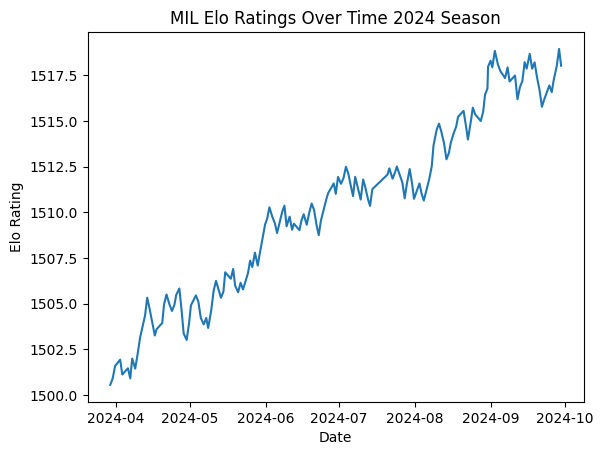

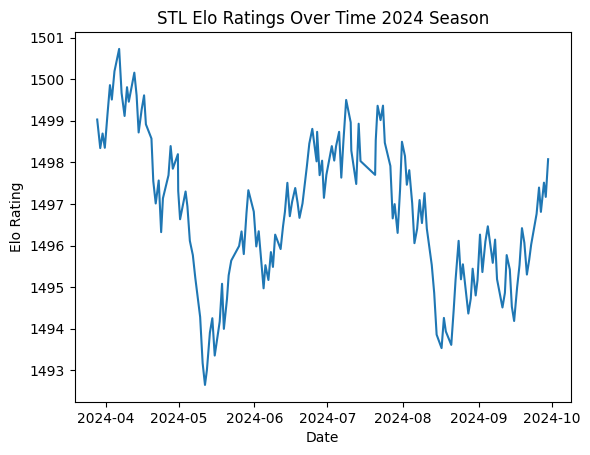

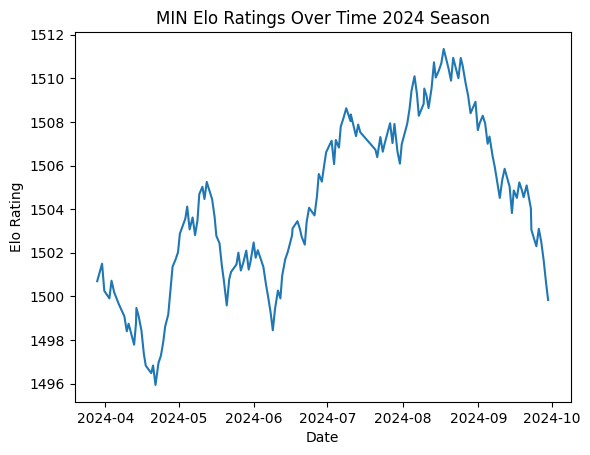

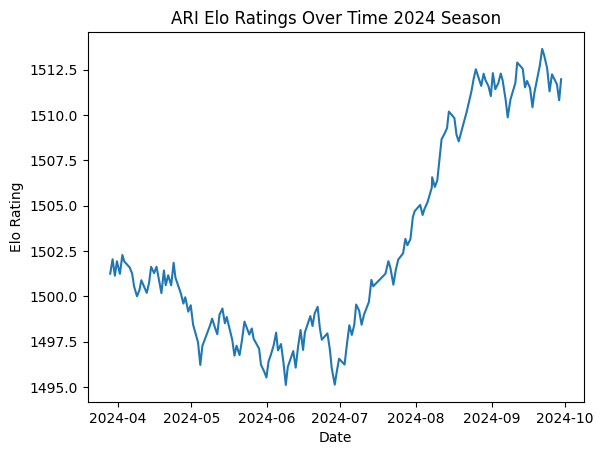

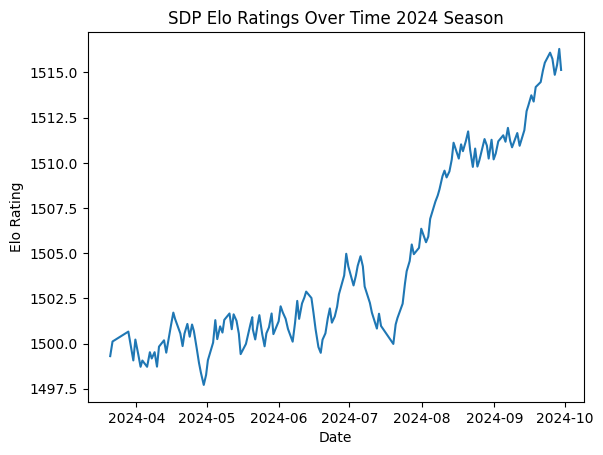

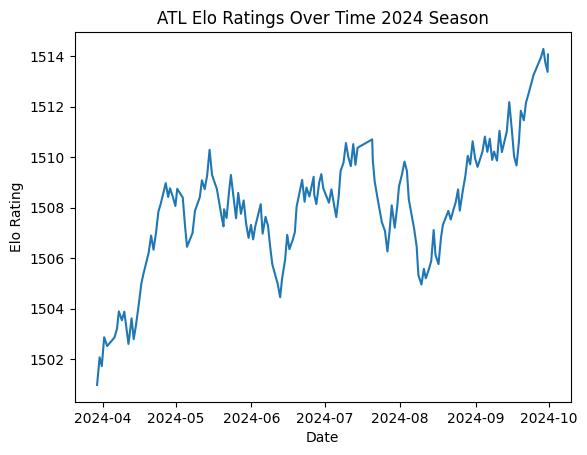

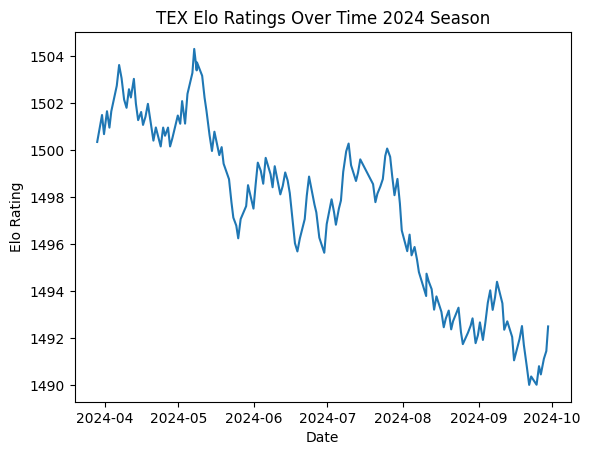

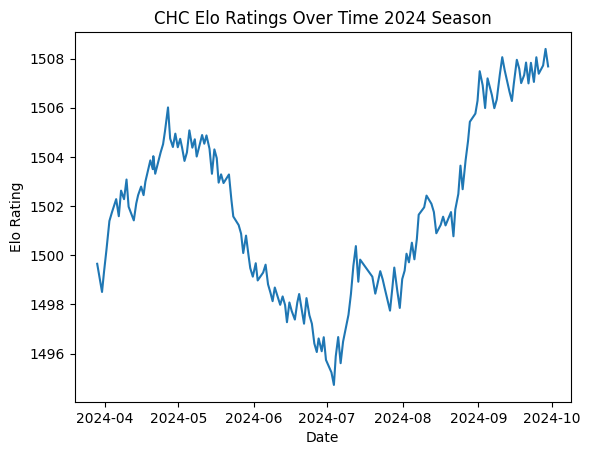

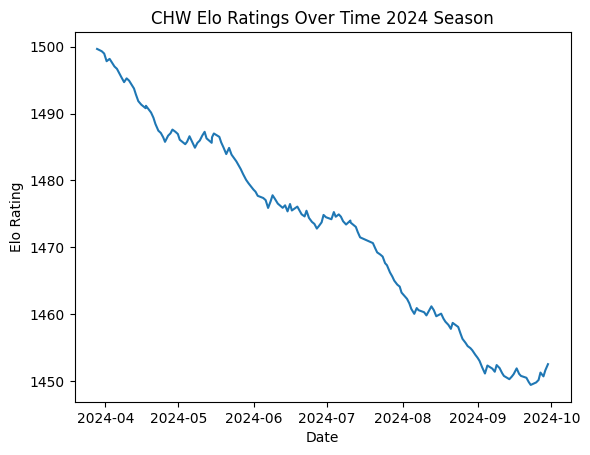

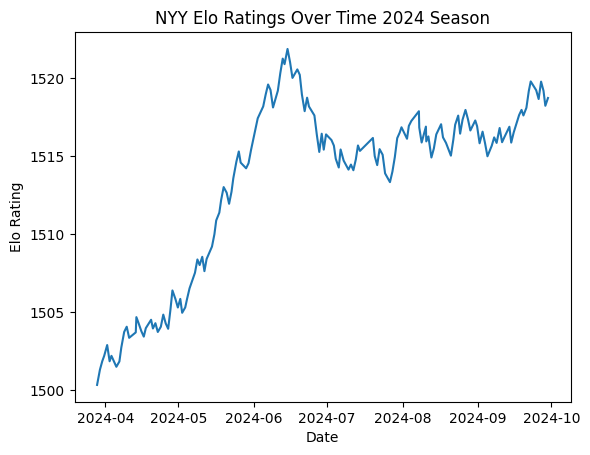

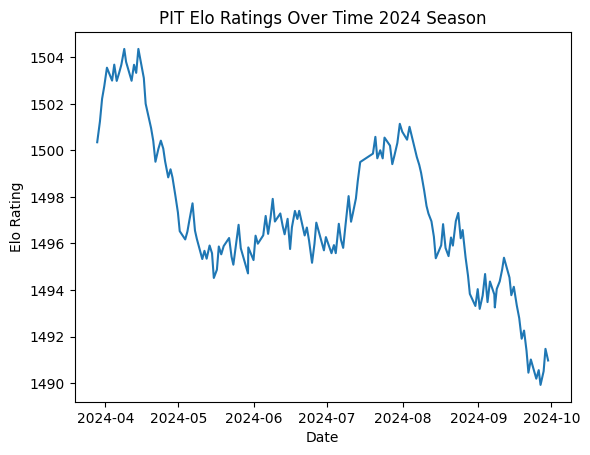

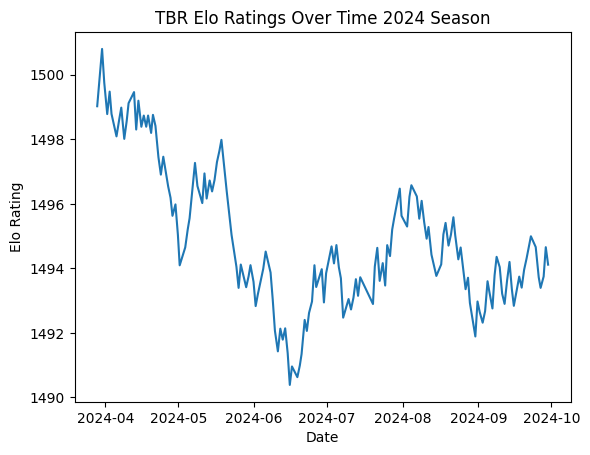

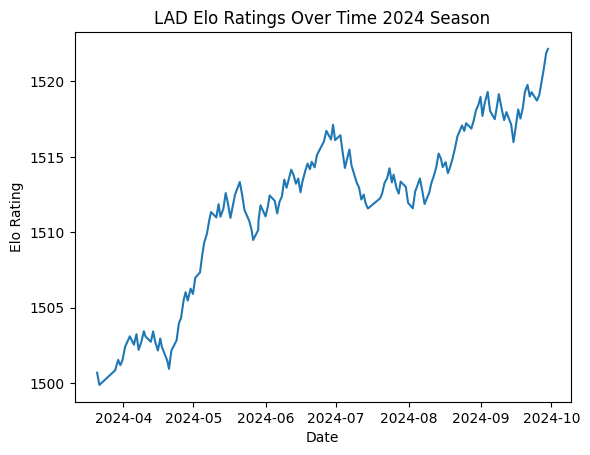

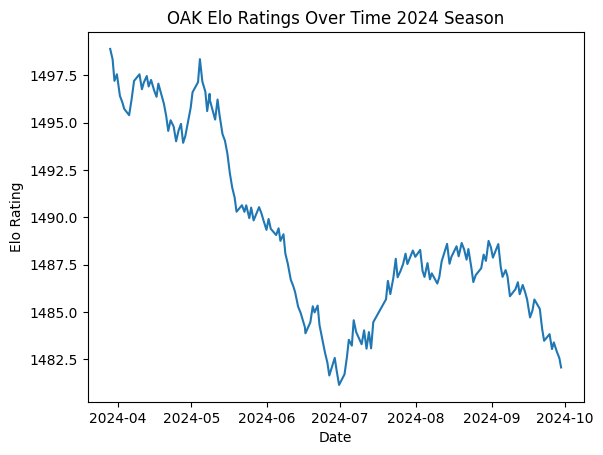

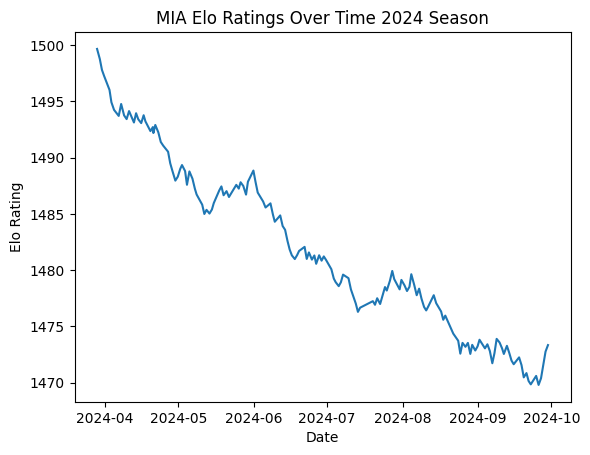

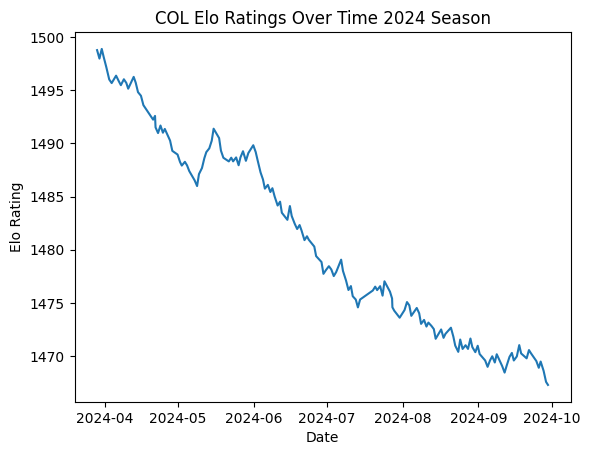

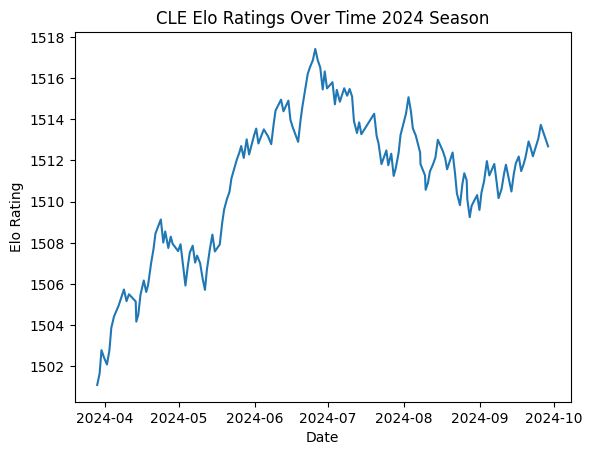

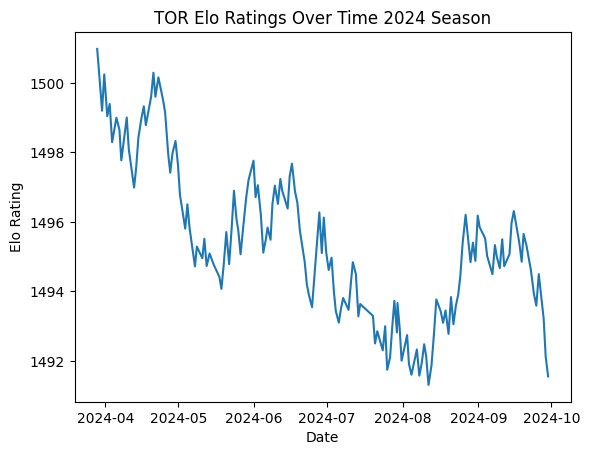

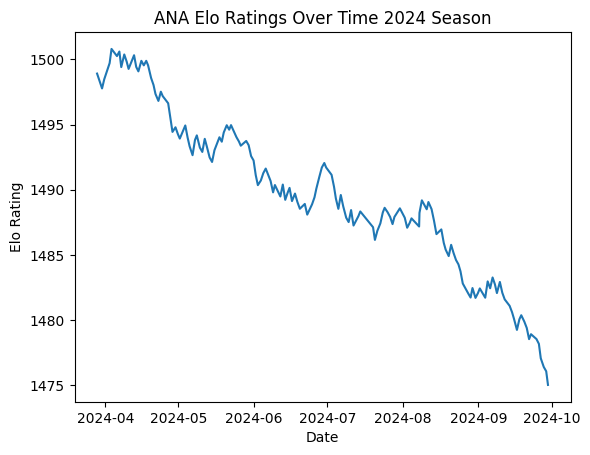

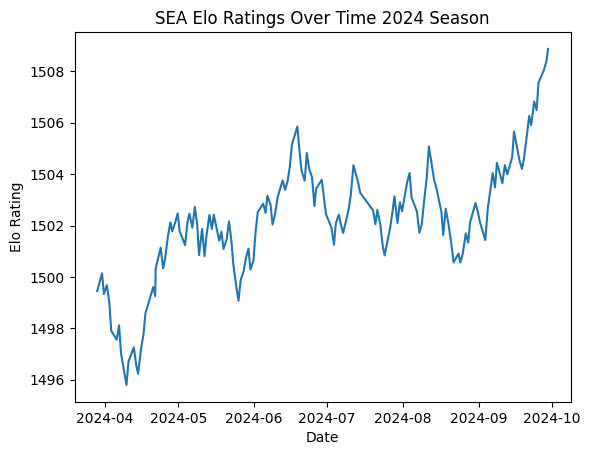

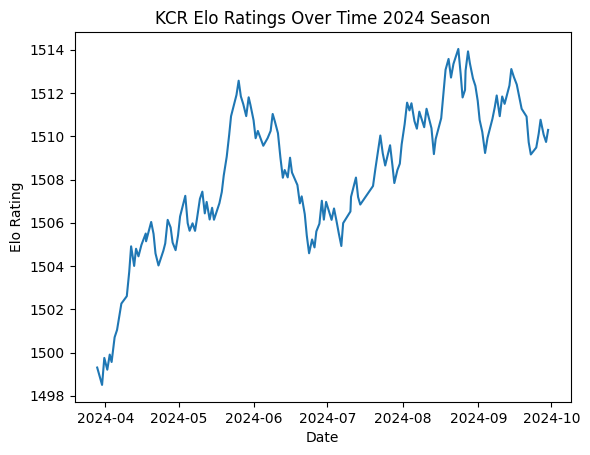

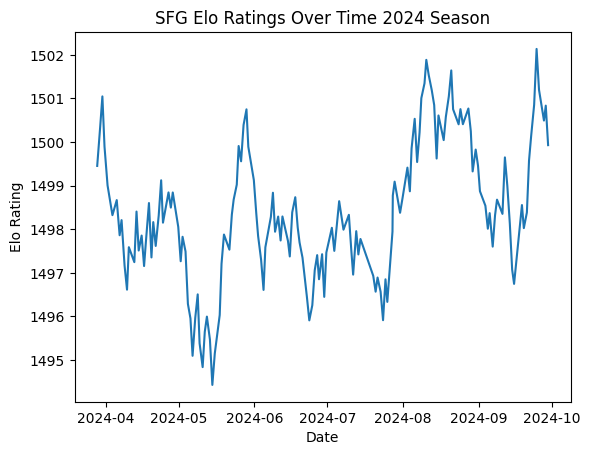

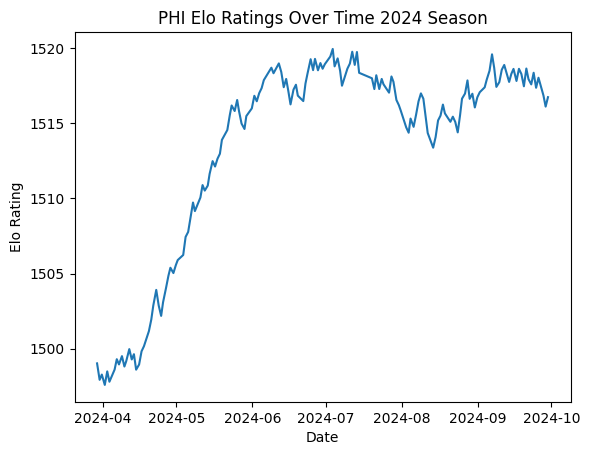

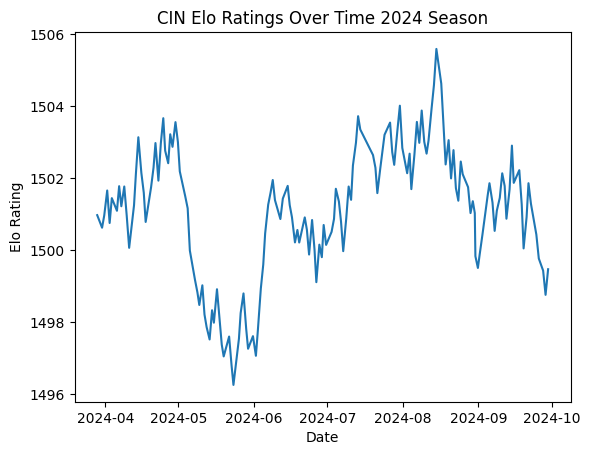

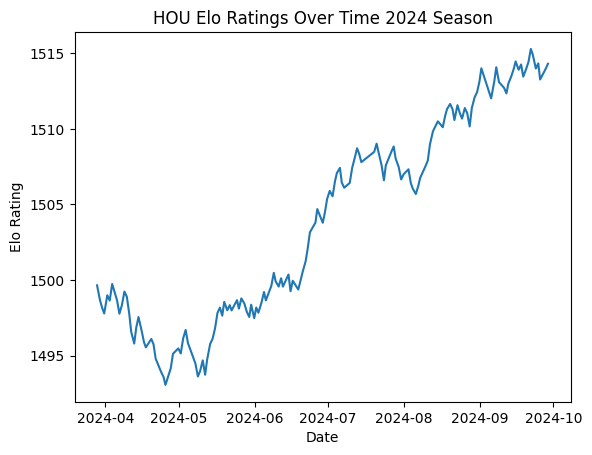

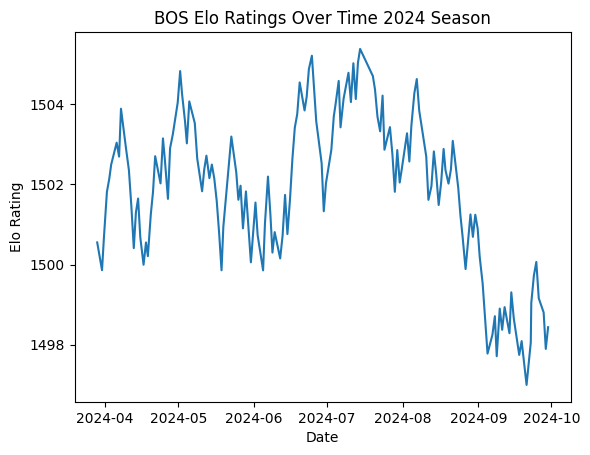

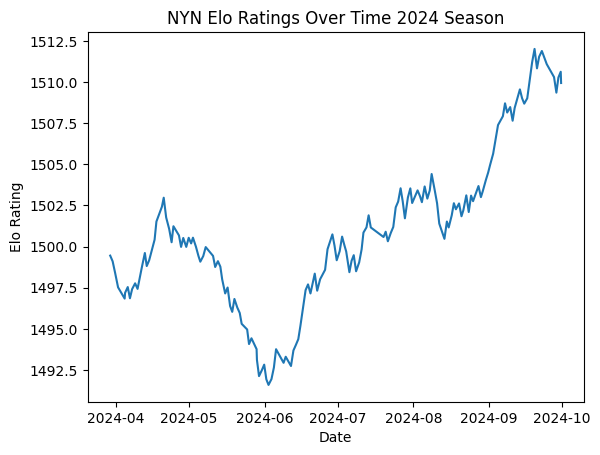

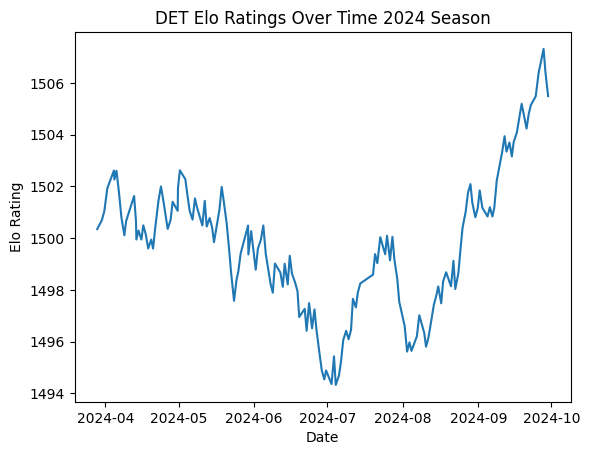

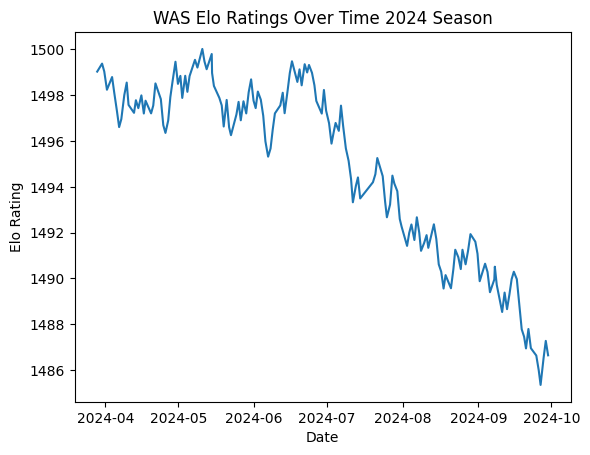

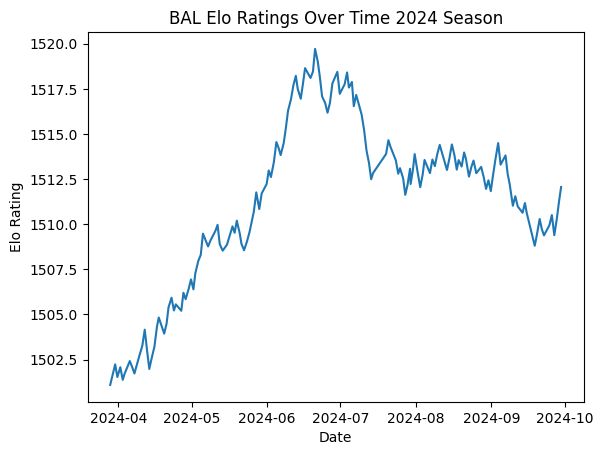

In [ ]:
for team in teams:
    team_df = team_history_df.filter(pl.col("team") == team)
    plt.plot(team_df.select(pl.col("date")), team_df.select(pl.col("elo")), label=team)
    plt.xlabel("Date")
    plt.ylabel("Elo Rating")
    plt.title(f"{team} Elo Ratings Over Time 2024 Season")
    plt.show()

In [ ]:
teams_to_plot = ["MIA", "HOU"]
subset = team_history_df.filter(pl.col("team").is_in(teams_to_plot))

In [ ]:
subset.head()

date,team,elo
datetime[μs],str,f64
2024-03-28 15:10:00,"""HOU""",1499.652429
2024-03-28 16:10:00,"""MIA""",1499.652429
2024-03-29 19:10:00,"""HOU""",1498.678928
2024-03-29 19:10:00,"""MIA""",1498.756046
2024-03-30 16:10:00,"""MIA""",1497.788352


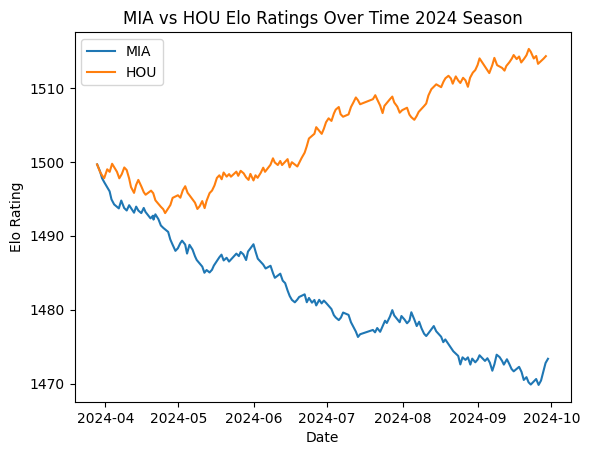

In [ ]:
for team in teams_to_plot:
    team_df = subset.filter(pl.col("team") == team)
    plt.plot(team_df.select(pl.col("date")), team_df.select(pl.col("elo")), label=team)

plt.title(f"{teams_to_plot[0]} vs {teams_to_plot[1]} Elo Ratings Over Time 2024 Season")
plt.xlabel("Date")
plt.ylabel("Elo Rating")
plt.legend()
plt.show()

In [ ]:
# Print end of season Elo ratings for all teams
print("End of Season Elo Ratings:")
print("-" * 30)
for team, elo in sorted(ratings.items(), key=lambda x: x[1], reverse=True):
    print(f"{team}: {elo:.2f}")

End of Season Elo Ratings:
------------------------------
LAD: 1522.15
NYY: 1518.75
MIL: 1518.02
PHI: 1516.74
SDP: 1515.14
HOU: 1514.31
ATL: 1514.07
CLE: 1512.68
BAL: 1512.06
ARI: 1511.98
KCR: 1510.29
NYN: 1509.94
SEA: 1508.87
CHC: 1507.68
DET: 1505.49
SFG: 1499.93
MIN: 1499.83
CIN: 1499.47
BOS: 1498.44
STL: 1498.08
TBR: 1494.11
TEX: 1492.50
TOR: 1491.55
PIT: 1490.97
WAS: 1486.64
OAK: 1482.07
ANA: 1475.04
MIA: 1473.35
COL: 1467.30
CHW: 1452.54


These seem like pretty reasonable results. ...